In [1]:
from os import listdir, environ
from sys import path

from science_parse_api.api import parse_pdf
from pathlib import Path

import pandas as pd

import json
import ast
import nltk

import openai
from openai.error import RateLimitError, InvalidRequestError
import backoff

In [2]:
openai.organization = environ.get('OPEN_AI_ORG')
openai.api_key = environ.get('OPEN_AI_API_KEY')

In [3]:
def parse_paragraphs(directory = './SeNp_research_articles/'):
    pdf_dirs = [directory]
    pdf_files = [pdf_dirs[0]+i for i in listdir(pdf_dirs[0])]
    
    # sci parse host
    host = 'http://127.0.0.1'
    port = '8080'
    
    paragraphs = {}
    for fl in pdf_files:
        pth = Path('./', fl).resolve()
        parsed = parse_pdf(host, pth, port=port)
        paragraphs[fl]=parsed

    df = pd.DataFrame()
    df['file'] = paragraphs.keys()
    df['content'] = paragraphs.values() 
    df['id'] = df.content.map(lambda x: x.get('id'))
    df['title'] = df.content.map(lambda x: x.get('title'))
    df['abstractText'] = df.content.map(lambda x: x.get('abstractText'))
    df['year'] = df.content.map(lambda x: x.get('year'))
    df['authors'] = df.content.map(lambda x: x.get('authors'))
    df['references'] = df.content.map(lambda x: x.get('references'))
    df['sections'] = df.content.map(lambda x: x.get('sections'))

    df_paragraphs = df[['file', 'id', 'title', 'year', 'authors', 'sections']].copy()\
    .explode('sections').reset_index(drop=True)

    df_paragraphs = df_paragraphs[df_paragraphs['sections'].map(lambda x: len(x.get('text'))>0)].copy()

    df_paragraphs.reset_index(drop=True, inplace=True)

    return(df_paragraphs)

In [4]:
@backoff.on_exception(backoff.expo, RateLimitError)
def text_cleaning(text, model="gpt-4-turbo-preview"):
    # print(len(text.split(' ')))
    messages = []
    
    messages.append({"role": "system", "content":'''# who you are: you are helpful assistant, expert in biochemistry.
    # your task: remove artefacts from not so good parsed scientific text sections.
    # you will take input in format: section text
    # you will respond: section text cleaned from artefacts'''})

    messages.append({"role": "user", "content": text})

    try:
        response = openai.ChatCompletion.create(model=model, messages=messages, max_tokens=4095, temperature=1)
    except InvalidRequestError as e:
        print(f"Error: {e}")
        

    # Print the response and add it to the messages list
    chat_message = response['choices'][0]['message']['content']
    # print(len(chat_message.split(' ')))
    # print(f"Bot: {chat_message}")
    # messages.append({"role": "assistant", "content": chat_message})
    print('*', end = "")
    return(chat_message)

In [25]:
@backoff.on_exception(backoff.expo, RateLimitError)
def extract_stabilizers(paragraph, model="gpt-4-turbo-preview"):
    messages = []
    
    messages.append({"role": "system", "content":'''# who you are: you are helpful assistant, expert in biochemistry.
    # your task: extract organic molecule used for stabilization or functionalization of Selenium nanoparticles, and summarize theirs function if explained in pragraph.
    # hint: the summary should be stated like keywords up to 5 words maximum.
    # you will take input in format: #####<paragraph>#####
    # you will respond: protein_1:<summary_of_protein_1_function>; protein_2:<summary_of_protein_2_function>; ...
    # response hint: if there is no protein in pragraph then respond with ##NOTHING##. if there is no explined function of protein in paragrah you will respond like protein_1:<##NO_SUMMARY##>.'''})

    messages.append({"role": "user", "content": '#####'+paragraph+'#####'})

    try:
        response = openai.ChatCompletion.create(model=model, messages=messages, max_tokens=4095, temperature=1)
    except InvalidRequestError as e:
        print(f"Error: {e}")
        

    # Print the response and add it to the messages list
    chat_message = response['choices'][0]['message']['content']
    # print(f"Bot: {chat_message}")
    print('*', end = "")
    # messages.append({"role": "assistant", "content": chat_message})
    return(chat_message)

In [45]:
@backoff.on_exception(backoff.expo, RateLimitError)
def extract_stabilizers_1(paragraph, model="gpt-4-turbo-preview"):
    messages = []
    
    messages.append({"role": "system", "content":'''# who you are: you are reserach assistant, expert in biochemistry.
    # your task: extract amino acid, peptide, polypeptide or protein used for stabilization of Selenium nanoparticles (SeNp, SeNP, something@SeNP).
    # you will take input in format: #####<paragraph>#####
    # you will respond: protein_1; protein_2; ...
    # response hint: if there is no protein used for stabilization in pragraph then respond with ##NOTHING##.'''})

    messages.append({"role": "user", "content": '#####'+paragraph+'#####'})

    try:
        response = openai.ChatCompletion.create(model=model, messages=messages, max_tokens=4095, temperature=1)
    except InvalidRequestError as e:
        print(f"Error: {e}")
        

    # Print the response and add it to the messages list
    chat_message = response['choices'][0]['message']['content']
    # print(f"Bot: {chat_message}")
    print('*', end = "")
    # messages.append({"role": "assistant", "content": chat_message})
    return(chat_message)

In [5]:
df_paragraphs = parse_paragraphs(directory='./SeNp_review_articles/')

In [6]:
df_paragraphs['section_text_splited'] = \
df_paragraphs['sections'].map(lambda x: x.get('text').split('\n'))

In [7]:
df_paragraphs_exploded = \
df_paragraphs.explode('section_text_splited')

In [8]:
df_paragraphs_exploded['words_number'] = \
df_paragraphs_exploded['section_text_splited']\
.map(lambda x: len(x.split(' ')))

In [9]:
df_paragraphs_exploded['words_number'].value_counts()

words_number
2      1838
6       210
3       106
4        79
1        78
       ... 
265       1
252       1
145       1
172       1
401       1
Name: count, Length: 296, dtype: int64

<Axes: ylabel='Frequency'>

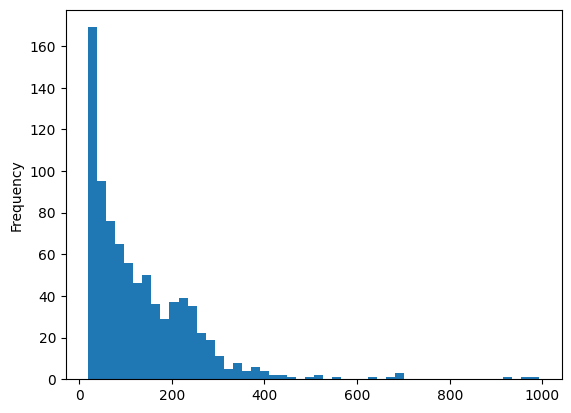

In [10]:
df_paragraphs_exploded[df_paragraphs_exploded['words_number']>=20]\
['words_number'].plot(kind='hist', bins=50)

In [11]:
df_paragraphs_exploded = \
df_paragraphs_exploded[df_paragraphs_exploded['words_number']>=20].copy()

In [12]:
df_paragraphs_exploded['section_text_splited_cleaned'] = \
df_paragraphs_exploded['section_text_splited']\
.map(lambda x: text_cleaning(text = x, model = 'gpt-3.5-turbo'))

*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [26]:
df_paragraphs_exploded['stabilizer_functions'] = df_paragraphs_exploded['section_text_splited_cleaned']\
.map(lambda x: extract_stabilizers(x))

*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [46]:
df_paragraphs_exploded['stabilizer_functions_1'] = df_paragraphs_exploded['section_text_splited_cleaned']\
.map(lambda x: extract_stabilizers_1(x))

*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [51]:
protein_stabilizers = \
df_paragraphs_exploded[df_paragraphs_exploded['stabilizer_functions_1']!='##NOTHING##']\
['stabilizer_functions_1'].map(lambda x: x.split(';'))

In [75]:
protein_stabilizers.explode().map(lambda x: x.lstrip(' ').rstrip(' ').rstrip("##").lower())\
.map(lambda x: x[:-11] if x.endswith("##nothing##") else x)\
.map(lambda x: x[:-9] if x.endswith("##nothing") else x)\
.value_counts()

stabilizer_functions_1
human serum albumin                                      3
bsa                                                      3
lysozyme                                                 2
selenoproteins                                           2
tf                                                       2
silk fibroin                                             2
cytochrome c3                                            2
lysozymes                                                2
selenomethionine                                         2
selenocysteine                                           2
psp                                                      2
chitosan                                                 2
insulin                                                  2
mushroom polysaccharide protein complex                  2
selenoprotein p                                          1
keratin                                                  1
bovine serum albumin             

In [87]:
df_paragraphs_exploded[df_paragraphs_exploded['section_text_splited_cleaned']\
.map(lambda x: 'lysozyme' in x.lower())][['file', 'section_text_splited_cleaned']].iloc[-1]\
['section_text_splited_cleaned']

'The typical X-ray diffraction (XRD) pattern revealed the polymorph, while the prepared nano selenium (Se) was amorphous. In Fourier-transform infrared spectroscopy (FTIR) spectra analysis confirmed the presence of lysozyme binding protein (LBP) on the surface of Se nanoparticles (NPs). The stretching vibration peak of hydroxide was blue-shifted from 3392 cm−1 to 3377 cm−1, suggesting that Se interacted with the hydroxyl group from LBP. The LBP-GT-SeNPs were spherical in shape and stable. The functionalized nanoparticles demonstrated high 2,2-diphenyl-1-picrylhydrazyl (DPPH) scavenging ability and 2,2′-azino-bis(3-ethylbenzothiazoline-6-sulfonic acid) (ABTS) scavenging ability. The impact of LBP-GT-SeNPs against oxidative stress-induced cell death was investigated by MTT assay. LBP-GT-SeNPs protected PC12 cells against H2O2-induced toxicity, with cells treated with LBP-GT-SeNPs and H2O2 exhibiting 90% viability. These results suggest that SeNPs have the potential for utilization as foo

In [88]:
df_paragraphs_exploded['stabilizer_functions_1_splited_not_cleaned'] = df_paragraphs_exploded['section_text_splited']\
.map(lambda x: extract_stabilizers_1(x))

*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [93]:
protein_stabilizers_not_clean_pragraphs = \
df_paragraphs_exploded[df_paragraphs_exploded['stabilizer_functions_1_splited_not_cleaned']!='##NOTHING##']\
['stabilizer_functions_1'].map(lambda x: x.split(';')).explode()

In [177]:
protein_stabilizers_extracted = \
protein_stabilizers_not_clean_pragraphs[protein_stabilizers_not_clean_pragraphs!="##NOTHING##"]\
.map(lambda x: x[:-11] if "##NOTHING##" in x else x)\
.map(lambda x: x[:-2] if x.endswith("##") else x)\
.map(lambda x: x.lower().lstrip(' ').rstrip(' '))\
.map(lambda x: 'bsa' if x=='bovine serum albumin' else x).value_counts().reset_index()

In [178]:
protein_stabilizers_extracted

,stabilizer_functions_1,count
0,bsa,4
1,lysozyme,2
2,tf,2
3,cytochrome c3,2
4,silk fibroin,2
5,human serum albumin,2
6,chitosan,2
7,insulin,2
8,mushroom polysaccharide protein complex,2
9,ox26,1


In [133]:
protein_stabilizers_extracted.shape

(38, 2)

In [140]:
stabilzers_table = \
pd.concat([protein_stabilizers_extracted[:10].reset_index(drop=True)\
           .rename(columns={'stabilizer_functions_1':'stabilizers', 'count':'freq'}), \
           protein_stabilizers_extracted[10:20].reset_index(drop=True)\
           .rename(columns={'stabilizer_functions_1':'stabilizers.', 'count':'freq.'}), \
           protein_stabilizers_extracted[20:30].reset_index(drop=True)\
           .rename(columns={'stabilizer_functions_1':'stabilizers..', 'count':'freq..'}), \
           protein_stabilizers_extracted[30:].reset_index(drop=True)\
           .rename(columns={'stabilizer_functions_1':'stabilizers...', 'count':'freq...'})], axis=1)

In [176]:
df_paragraphs_exploded[df_paragraphs_exploded['section_text_splited']\
.map(lambda x: 'rgdfc' in x.lower())][['file', 'section_text_splited_cleaned']]

,file,section_text_splited_cleaned
53,./SeNp_review_articles/ijms-22-10808-v3.pdf,SeNP exhibit a cytotoxic effect on prostate ca...
168,./SeNp_review_articles/fimmu-13-956181.pdf,Nanomedicine has been high-profile for decades...
168,./SeNp_review_articles/fimmu-13-956181.pdf,Recent studies have also proved that Selenium ...


In [187]:
_description_ = \
{'tf':'transferin protein', 'chitosan':'polysacharide', 
 'ox26':'monoclonal antibodies antitransferin recepotor', 
 'sparc': 'secreted protein and rich in cysteine', 
 'pacap-derived peptide dbayl':'pituitary adenylate catalase activating peptide (conjugated chitosan)', 
 'eadf4(k16)':'positively charged spider silk protein eADF4(k16)', 
 'reductase protein': 'reduction enzyme hydrogen donor', 
 'horseradish peroxidase': 'horseradish peroxidase interacts with Se surface', 
 'gpx': 'glutathione peroxidase', 
 'hsp-70':'heat shock protein effect enhancement in presence of Se', 
 'keratin':'used for production of SeNp with BSA', 
 'thioredoxin reductase':'SeNp more eﬃcient as a cofactor for both thioredoxin reductases and glutathione perox-idases', 
 'psp':'polysaccharide–protein', 'dio2':'selenoprotein', 
 'sef a': 'Sef A protein stabilize SeNp', 'rgdfc':'RGDfC (cyclic peptide) modiﬁed Se NPs'}

In [190]:
_description_short_ = \
{'tf':'transferin protein', 'chitosan':'polysacharide', 
 'ox26':'monoclonal antibodies antitransferin recepotor', 
 'sparc': 'secreted protein and rich in cysteine', 
 'pacap-derived peptide dbayl':'pituitary adenylate catalase activating peptide', 
 'eadf4(k16)':'positively charged spider silk protein eADF4(k16)',  
 'gpx': 'glutathione peroxidase', 
 'hsp-70':'heat shock protein', 
 'psp':'polysaccharide–protein', 'dio2':'selenoprotein', 
 'sef a': 'Sef A protein', 'rgdfc':'RGDfC (cyclic peptide)'}

In [194]:
protein_stabilizers_extracted = \
protein_stabilizers_not_clean_pragraphs[protein_stabilizers_not_clean_pragraphs!="##NOTHING##"]\
.map(lambda x: x[:-11] if "##NOTHING##" in x else x)\
.map(lambda x: x[:-2] if x.endswith("##") else x)\
.map(lambda x: x.lower().lstrip(' ').rstrip(' '))\
.map(lambda x: 'bsa' if x=='bovine serum albumin' else x)\
.map(lambda x: 'lysozyme' if x=='lysozymes' else x)\
.map(lambda x: 'glutathione peroxidase' if x=='gpx' else x)\
.map(lambda x: 'transferrin' if x=='tf' else x).value_counts().reset_index()

In [195]:
protein_stabilizers_extracted['full name'] = \
protein_stabilizers_extracted['stabilizer_functions_1']\
.map(lambda x: _description_short_.get(x))

In [199]:
protein_stabilizers_extracted.columns = ['molecule', 'freq', 'desc']

In [205]:
pd.concat([protein_stabilizers_extracted[:7].reset_index(drop=True),\
           protein_stabilizers_extracted[7:14].reset_index(drop=True),\
           protein_stabilizers_extracted[14:21].reset_index(drop=True),\
           protein_stabilizers_extracted[21:28].reset_index(drop=True),\
           protein_stabilizers_extracted[28:].reset_index(drop=True)], axis=1)

,molecule,freq,desc,molecule,freq,desc,molecule,freq,desc,molecule,freq,desc,molecule,freq,desc
0,bsa,4,None,glutathione peroxidase,2,None,sparc,1,secreted protein and rich in cysteine,selenocysteine,1,None,cytochrome c4,1,None
1,lysozyme,3,None,insulin,2,None,pacap-derived peptide dbayl,1,pituitary adenylate catalase activating peptide,selenos,1,None,dio2,1,selenoprotein
2,transferrin,3,None,chitosan,2,polysacharide,eadf4(k16),1,positively charged spider silk protein eADF4(k16),reductase protein,1,None,selenon,1,None
3,mushroom polysaccharide protein complex,2,None,selenok,1,None,horseradish peroxidase,1,None,polysaccharide and protein complex of edible m...,1,None,selenof,1,None
4,human serum albumin,2,None,keratin,1,None,hsp-70,1,heat shock protein,thioredoxin reductase,1,None,selenot,1,None
5,silk fibroin,2,None,streptavidin,1,None,psp,1,polysaccharide–protein,selenomethionine,1,None,selenom,1,None
6,cytochrome c3,2,None,ox26,1,monoclonal antibodies antitransferin recepotor,selenoproteins,1,None,sef a,1,Sef A protein,rgdfc,1,RGDfC (cyclic peptide)


In [206]:
# df_paragraphs_exploded.to_pickle(path = 'extracted_stabilizers_from_reviews.pkl')

In [208]:
# protein_stabilizers_extracted.to_pickle(path = 'protein_stabilizers.pkl')

In [209]:
protein_stabilizers_extracted

,molecule,freq,desc
0,bsa,4,None
1,lysozyme,3,None
2,transferrin,3,None
3,mushroom polysaccharide protein complex,2,None
4,human serum albumin,2,None
5,silk fibroin,2,None
6,cytochrome c3,2,None
7,glutathione peroxidase,2,None
8,insulin,2,None
9,chitosan,2,polysacharide
